In [1]:
import model
import numpy as np
import random
import tank
import truck

import gym_pdsystem

import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import animation, rc
import matplotlib.patches as mpatches

from IPython.display import HTML

import pandas as pd
import time

from gym_pdsystem.envs.pdsystem_env import PDSystemEnv
import gym_pdsystem.utils.utilsq as ut
import gym_pdsystem.utils.constants as ct
import gym_pdsystem.utils.functions as fnc

import os

simulations_directory = './simulations'
if not os.path.exists(simulations_directory):
    os.makedirs(simulations_directory)


In [11]:
COEFF = ct.COEFF

C_TRANSPORT = ct.C_TRANSPORT
C_LEVELS = ct.C_LEVELS

p0_GLOBAL = ct.p0_GLOBAL

P1_GLOBAL = ct.P1_GLOBAL
P2_GLOBAL = ct.P2_GLOBAL

M_GLOBAL = ct.M_GLOBAL

NOT_DELIVERYING_PENALTY = P2_GLOBAL #to be equivalent/same importance as having 0 stock or surpassing max capacity levels


## System initializer

In [2]:
def initialize_test_system(noise = False, seed = None):
    if seed != None:
        np.random.seed(seed)

    # Tanks' information
    global n
    n = 5 
    tank_ids = list(range(1,n+1))
    tank_max_loads =  np.array([100., 200, 100., 800., 200.])
    C_max = np.array([ [load] for load in tank_max_loads ])

    tank_current_loads = np.full(n,0)
    tank_consumption_rates =  np.array([5.] * n)
    noisy_consumption_rate = noise
    
    global n_discrete_load_levels
    n_discrete_load_levels = np.array([4,4,4,4,4])
    
    load_level_percentages = np.array([ #b , c, e
                                            [0.02, 0.31, 0.9],
                                            [0.01, 0.03, 0.9],
                                            [0.05, 0.16, 0.9],
                                            [0.07, 0.14, 0.85],
                                            [0.08, 0.26, 0.9]
                                               ])
    for i in range(n):
        tank_consumption_rates[i] = tank_max_loads[i] * (load_level_percentages[i][0] + load_level_percentages[i][1])/2.0
        
    tank_levels = np.multiply(C_max,load_level_percentages)
    
    for i, tank_level in enumerate(tank_levels):
                a = tank_level[0]
                b = tank_level[-1]
                #current_load = 0.75 * (a+b)/2.0# np.random.randint(a+1,b, size =(1,)) GIVES A STRANGE ERROR
                current_load = np.random.random() * (b - a-1) + a+1 #np.random.randint(a+1,b)
                tank_current_loads[i] = current_load * 1.0
                
#     for i, (lvl, max_load) in enumerate(zip(n_discrete_load_levels, tank_max_loads)):
#         a = np.linspace(0,max_load, lvl+1)[1]
#         current_load = np.random.randint(a+1,max_load)
#         tank_current_loads[i] = current_load     

    # Trucks' information
    global k
    k = 2
    truck_ids = list(range(k))
    truck_max_loads = np.array([70.,130.])
    truck_current_loads = truck_max_loads.copy()
    truck_current_positions =  np.array([5] * k)
    #truck_fractions_deliverable =  np.array([1.] * k) # we for now we only allow to deliver all the content of the truck
    truck_fractions_deliverable =  np.array([ np.array([1.]), 
                                              np.array([1.])
                                            ]) # we for now we only allow to deliver all the content of the truck
    global n_discrete_load_levels_trucks
    n_discrete_load_levels_trucks = np.array([1,1])

    # System's information
   
    graph = ut.simple_graph(n+1)
    tanks = [tank.Tank( tank_id, current_load, max_load, consumption_rate, n_lvls, d_lvls, noisy_consumption_rate) 
             for  tank_id, current_load, max_load, consumption_rate, n_lvls, d_lvls in 
             zip( tank_ids, tank_current_loads, tank_max_loads, tank_consumption_rates, n_discrete_load_levels,
                  load_level_percentages)]
    trucks = [truck.Truck( truck_id, current_load, max_load, current_position, load_fractions_deliverable, n_lvls) 
             for  truck_id, current_load, max_load, current_position, load_fractions_deliverable, n_lvls in 
             zip(truck_ids, truck_current_loads, truck_max_loads, truck_current_positions, 
                 truck_fractions_deliverable, n_discrete_load_levels_trucks)]

    w =  np.array([32., 159., 162., 156.,156., 0.])

    weights_matrix = ut.simple_weights(n+1, w)
    
    return(tanks, trucks, graph, weights_matrix)

tanks, trucks, graph, weights_matrix = initialize_test_system()
toy_system = model.System(tanks = tanks, trucks = trucks, adjacency_matrix = graph, weights_matrix = weights_matrix)

# Action-State space dimension
a_s_dim = toy_system.states_dim * toy_system.actions_dim
a_s_dim

368640

In [4]:
tanks, trucks, graph, weights_matrix = initialize_test_system(seed = 42)
system = model.System(tanks = tanks, trucks = trucks, adjacency_matrix = graph, weights_matrix = weights_matrix)
print(system.tank_loads())
print(system.graph)
print(system.weights)

[35, 171, 67, 429, 42]
[[0 0 0 0 0 0]
 [0 0 0 0 0 0]
 [0 0 0 0 0 0]
 [0 0 0 0 0 0]
 [0 0 0 0 0 0]
 [1 1 1 1 1 1]]
[[ inf  inf  inf  inf  inf  inf]
 [ inf  inf  inf  inf  inf  inf]
 [ inf  inf  inf  inf  inf  inf]
 [ inf  inf  inf  inf  inf  inf]
 [ inf  inf  inf  inf  inf  inf]
 [ 32. 159. 162. 156. 156.   0.]]


### Reinitialize system function

In [3]:
def reinitialize_system(system, seed = None):
    if seed != None:
        np.random.seed(seed)
        
    for tank, tank_levels in zip(system.tanks, system.tanks_level):
        a = tank_levels[0]
        b = tank_levels[-1]
        current_load = np.random.random() * (b - a-1) + a+1 #np.random.randint(a+1,b)*1.0
        tank.load = current_load
    system.reset_trucks_positions(); 
    return(system)    

## Q-learning algorithm (off-policy)


### Training

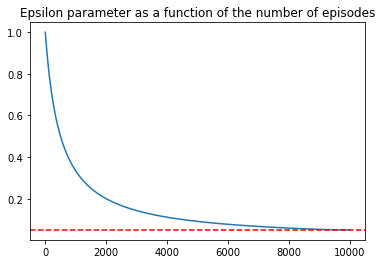

In [4]:
# Retrain parameters:
retrain = False

episode_retrain = 2*10**3 # episode number from which start the retrain. Ensure that a file with this number in 
                          # the Q filename is available.
retrain_episodes = 1*10**3


# Train parameters:
train_epsilon = True

learning_rate0 = 1 
learning_rate_decay = 0 

episode_length = 30
discount_rate = 0.9

episodes = 10**4
episodes_epsilon_min = 0.05*episodes

# Output's frequencies
train_freq = 10**2 # 10**4
train_vis_freq =  np.inf #10**3
train_rew_freq =  10**2
train_Q_freq =  10**3 #3

epsilon0 = 1.0
epsilon_decay =( 1./(episodes_epsilon_min) ) 
epsilon_min = 0.05

verbose = False
verbose_info = False

seed = 42

simulation_id = 29
add_noise = False

# Visualization of the epsilon parameter value that will be present duing the simulation
% matplotlib inline

def epsilon_fnc(x, epsilon0 = epsilon0, decay = epsilon_decay, epsilon_min = epsilon_min):
    e_mins = epsilon_min * np.ones(len(x))
    eps = epsilon0 / (1.0 + (x-1)*epsilon_decay)
    return np.maximum(e_mins, eps )

t = np.arange(1, episodes, 1)
epsilon = epsilon_fnc(t)

plt.plot(t, epsilon)
plt.axhline(y= epsilon_min, xmin=0, xmax=episodes, hold=None, color = "Red", linestyle = '--')

plt.title("Epsilon parameter as a function of the number of episodes");

In [5]:
train_visualization_steps = []
train_rewards_list = []

tanks, trucks, graph, weights_matrix = initialize_test_system(noise = add_noise, seed = seed)
toy_system = model.System(tanks = tanks, trucks = trucks, adjacency_matrix = graph, weights_matrix = weights_matrix)

Q = {}

# Create directories for the simulations' outputs

simulation_directory = './simulations/simulation{}'.format(simulation_id)
rewards_file = simulation_directory+'/discrewards'+ '/rewards-sim{}.csv'.format(simulation_id)
states_file = simulation_directory+'/vis'+ '/states-sim{}.csv'.format(simulation_id) # for testing

if not os.path.exists(simulation_directory):
    os.makedirs(simulation_directory)
    os.makedirs(simulation_directory + '/Q-dictionaries')
    os.makedirs(simulation_directory + '/discrewards')
    os.makedirs(simulation_directory + '/vis')
    
else:
    raise Exception("The simulation id you tried to use has been already used before. Try to change it to a new one.")

    
ut.save_obj(toy_system, simulation_directory+"/system-sim"+"{}".format(simulation_id)) 

# Output headers to file
with open(rewards_file,'w') as f:
     np.savetxt(f, [["episode", "discreward"]], fmt="%s", delimiter=',')         


Exception: The simulation id you tried to use has been already used before. Try to change it to a new one.

In [8]:
def episodic_train_Q_epsilon( 
            epsilon0 = epsilon0,
            epsilon_min = epsilon_min,
            n_episodes = episodes, 
            episode_length = episode_length,
            learning_rate0 = learning_rate0,
            learning_rate_decay = learning_rate_decay,
            discount_rate = discount_rate,
            system = toy_system,
            Q = Q, verbose = verbose, verbose_info = verbose_info,
            visualization_steps = train_visualization_steps, rewards_list = train_rewards_list,
            seed = seed, 
            freq = train_freq,
            vis_freq = train_vis_freq,
            rew_freq = train_rew_freq,
            Q_freq = train_Q_freq,
            simulation_id = simulation_id,
            round_time = 2
    
           ):
    
    time_start = time.time()
    
    for episode in range(1,n_episodes+1):
        print("\rEpisode: {}".format(episode), end="")

        reinitialize_system(system, seed = episode)
        
        ### epsilon-greedy exploration
        epsilon = max( epsilon_min, epsilon0 / (1+(episode-1)*epsilon_decay) ) 
        
        ### decrement of learning rate
        learning_rate = learning_rate0 / (1+(episode-1)*learning_rate_decay)        

        discounted_reward = 0
        
        for t in range(episode_length):

            system.update_state()
            s_current = system.state_to_string()                
            p = np.random.uniform()

            if p > epsilon:
                #DETERMINISTIC ACTION OPTIMAL
                s0 = system.state_to_string()
                best_action = optimal_policy(s0, Q)
                if best_action == None:
                    reward, _,_ = system.random_action(seed = (seed + (t+1)*episode), verbose = verbose)
                else:
                    reward, _ ,_ = system.deterministic_action(best_action)
                #print(best_action)
            else:
                reward,_ ,_ = system.random_action(seed = (seed + (t+1)*episode), verbose = verbose)

            a_current = system.action_to_string()
            sa_current = ''.join([s_current, a_current])

            system.update_state()
            sa_new = system.state_action_to_string()

            if ut.is_key(Q, sa_current) == False:
                Q[sa_current] = 0

            Q_max = max([Q[key] for key in Q.keys() if key.startswith(sa_new[0:system.state_length])]+[0.0]) 

            if Q[sa_current] != -np.inf:
                Q[sa_current] = ( (1-learning_rate) * Q[sa_current] 
                                 + learning_rate* (reward + discount_rate * Q_max)
                                )
                
            discounted_reward = discounted_reward + (discount_rate**t) * reward
            system.reset_trucks_positions();     
            system.reset_trucks_loads();
            
        #rewards_list.append(discounted_reward);
        if episode % freq == 0:
                time_end = time.time()
                print(". Elapsed time ", round( (time_end-time_start)/60., round_time), " minuts.",
                      "epsilon", round(epsilon,4), 
                     "Discounted reward: ", discounted_reward)
                
                if verbose_info:
                    print("s, a", system.s, system.a)
                    print("ds, da", system.ds, system.da)
        if episode % Q_freq == 0:           
                ut.save_obj(Q, simulation_directory +"/Q-dictionaries/Q-dict-sim" + "{}".format(simulation_id) + "-" + "{}".format(episode))   

        if episode % vis_freq == 0:
                #Save visualization and rewards
                visualization_steps.append(toy_system.visualize());
                ut.save_obj(visualization_steps, simulation_directory +"/vis/vis-train-sim" + "{}".format(simulation_id) + "-" + "{}".format(episode))   
                                
        if episode % rew_freq == 0:
                #rewards_list.append(discounted_reward);
                #ut.save_obj(rewards_list, simulation_directory +"/discrewards/discrew-train-sim" + f"{simulation_id}" + "-" + f"{episode}")
                # Output data to files
                with open(rewards_file,'ab') as f:
                    np.savetxt(f, [np.array([episode, discounted_reward])], fmt=("%d",'%.10f'), delimiter=',')    
        
    end_time = round(time.time()-time_start,round_time)        
    print("Training finished. Total episodes: {}. Elapsed time: {} minutes.".format(n_episodes,round(end_time/60., round_time)))        

In [6]:
# Given a state, returns the action that has the highest Q-value.

def optimal_policy(state, Q, system = toy_system):
    """
    state must be in the string-integers code
    """
    state_keys = [key for key in list(Q) if key.startswith(state)]
    if len(state_keys) == 0:
        return(None)
    
    state_q = [Q[state_key] for state_key in state_keys]
    
    #print("state_q ", state_q[1:min(10,len(state_q))])
    
    max_q = max(state_q)
    #print("max_q", max_q)
    optimal_key_index = np.where(np.isin(state_q, max_q ))[0][0]
    #print("optimal_key_index", optimal_key_index)
    optimal_key = state_keys[optimal_key_index]
    #print("optimal_key", optimal_key)
    optimal_action = optimal_key[system.state_length:]
    
    return(optimal_action)
    

In [10]:
if train_epsilon == True and retrain == False:
    episodic_train_Q_epsilon()
elif train_epsilon == False and retrain == True:
    Q_retrain = ut.load_obj(simulation_directory + "/Q-dictionaries/Q-dict-sim" + "{}".format(simulation_id) + "-" + "{}".format(episode_retrain))
    episodic_train_Q_epsilon(n_episodes = retrain_episodes, Q = Q_retrain)
else:
    raise Exception("Only one of the parameters train_epsilon or retrain parameters can be set to True.")
    

Episode: 100. Elapsed time  0.05  minuts. epsilon 0.8347 Discounted reward:  -17.780651993894804
Episode: 200. Elapsed time  0.11  minuts. epsilon 0.7153 Discounted reward:  -11.882802370193724
Episode: 300. Elapsed time  0.19  minuts. epsilon 0.6258 Discounted reward:  -6.723793147895944
Episode: 400. Elapsed time  0.28  minuts. epsilon 0.5562 Discounted reward:  -13.443287846537238
Episode: 500. Elapsed time  0.38  minuts. epsilon 0.5005 Discounted reward:  -13.93710756982247
Episode: 600. Elapsed time  0.49  minuts. epsilon 0.455 Discounted reward:  -15.88914827932583
Episode: 700. Elapsed time  0.61  minuts. epsilon 0.417 Discounted reward:  -8.618790691167113
Episode: 800. Elapsed time  0.73  minuts. epsilon 0.3849 Discounted reward:  -7.59844000195548
Episode: 900. Elapsed time  0.87  minuts. epsilon 0.3574 Discounted reward:  -8.837647016679382
Episode: 1000. Elapsed time  1.01  minuts. epsilon 0.3336 Discounted reward:  -8.892983724865138
Episode: 1100. Elapsed time  1.15  minu

Episode: 8500. Elapsed time  19.1  minuts. epsilon 0.0556 Discounted reward:  -4.220389014808183
Episode: 8600. Elapsed time  19.44  minuts. epsilon 0.055 Discounted reward:  -1.5288513066203981
Episode: 8700. Elapsed time  19.75  minuts. epsilon 0.0544 Discounted reward:  -1.1416631802267794
Episode: 8800. Elapsed time  20.04  minuts. epsilon 0.0538 Discounted reward:  -5.08383529134327
Episode: 8900. Elapsed time  20.36  minuts. epsilon 0.0532 Discounted reward:  -2.191184610623368
Episode: 9000. Elapsed time  20.64  minuts. epsilon 0.0526 Discounted reward:  -1.4643227192398425
Episode: 9100. Elapsed time  20.92  minuts. epsilon 0.0521 Discounted reward:  -0.5231173249303254
Episode: 9200. Elapsed time  21.24  minuts. epsilon 0.0516 Discounted reward:  -0.5975310753907888
Episode: 9300. Elapsed time  21.56  minuts. epsilon 0.051 Discounted reward:  -1.241948071944708
Episode: 9400. Elapsed time  21.82  minuts. epsilon 0.0505 Discounted reward:  -1.435905756422067
Episode: 9500. Elap

### Testing

In [7]:
# TEST PARAMETERS AND INITIALIZATION

# Initialize system
#episodes = 100000#243000
#simulation_id = 16 # comment when training
#simulation_directory = './simulations/simulation{}'.format(simulation_id) # comment when training


tanks, trucks, graph, weights_matrix = initialize_test_system(seed =episodes+1)
test_toy_system = model.System(tanks = tanks, trucks = trucks, adjacency_matrix = graph, weights_matrix = weights_matrix)

Q = ut.load_obj(simulation_directory + "/Q-dictionaries/Q-dict-sim" + "{}".format(simulation_id) + "-" + "{}".format(episodes))




In [8]:
test_episodes = 5
episode_length =30
test_freq = 1
test_verbose = False

test_visualization_steps = []
test_rewards_list = []
test_level_rewards_list = []
test_transport_rewards_list = []
test_trucks_sent_list = []
test_number_of_first_trucks_sent_list = []
test_number_of_second_trucks_sent_list = []

In [12]:
with open(states_file,'w') as f:
     np.savetxt(f, [["step", "stock0", "stock1", "stock2","stock3", "stock4"]], fmt="%s", delimiter=',')  


def test_Q(n_episodes = test_episodes, 
           episode_length = episode_length,
           system = test_toy_system,
           visualization_steps = test_visualization_steps, 
           rewards_list = test_rewards_list,
           level_rewards_list = test_level_rewards_list,
           transport_rewards_list = test_transport_rewards_list,
           trucks_sent_list = test_trucks_sent_list,
           number_of_first_trucks_sent_list =test_number_of_first_trucks_sent_list,
           number_of_second_trucks_sent_list = test_number_of_second_trucks_sent_list,
           freq = test_freq,
           test_verbose = test_verbose ,
           states_file = states_file, 
           Q = Q
          ):
    
    for episode in range(1,n_episodes+1): 
        print("\rTest episode: {}\n".format(episode), end="")
        reinitialize_system(system, seed = episode+episodes)

        discounted_reward = 0 
        transport_rewards = 0
        level_rewards = 0
        number_of_trucks_sent = 0
        number_of_first_trucks_sent = np.zeros(n+1, dtype = np.int64)
        number_of_second_trucks_sent = np.zeros(n+1, dtype = np.int64)

        
        for i in range(1,episode_length+1):
            #print("state", test_toy_system.s, test_toy_system.ds)
            system.update_state()

            #Save visualization steps
            if i % freq == 0:
                visualization_steps.append(system.visualize());
                state = system.state()
#                 print(state[2])
#                 print([i]+state[2])
                with open(states_file,'ab') as f:
                    np.savetxt(f, [np.array([(episode-1)*(episode_length)+i]+state[2])], fmt=("%d",'%.3f','%.3f','%.3f','%.3f','%.3f'), delimiter=',')    

            s0 = system.state_to_string()
            best_action = optimal_policy(s0, Q)
            #print("best_action", best_action)

            if best_action == None:
                reward, transport_reward, level_reward = system.random_action(None, test_verbose)
                if i % freq == 0:
                    if test_verbose == True:
                        print("Episode", episode, "t", i-1, round(reward,7), round(level_reward,7), round(transport_reward,7), "\nRandom action is performed. Current state unknown for Q.")

            else:
                reward, transport_reward, level_reward = system.deterministic_action(best_action, test_verbose)
                number_of_trucks_sent = number_of_trucks_sent + best_action.count('5')
                index1 = int(best_action[0])
                number_of_first_trucks_sent[index1] = number_of_first_trucks_sent[index1] + 1
                index2 = int(best_action[1])
                number_of_second_trucks_sent[index2] = number_of_second_trucks_sent[index2] + 1
                
                if i % freq == 0:
                    if test_verbose == True:
                        print("Episode", episode, "t",i-1,round(reward,7),round(level_reward,7), round(transport_reward,7), best_action)

            system.reset_trucks_positions();
            system.reset_trucks_loads();
            
            discounted_reward = discounted_reward + (discount_rate**(i-1)) * reward
            transport_rewards = transport_rewards+transport_reward
            level_rewards = level_rewards + level_reward
            
            if reward <= P2_GLOBAL:
                print("\rSome tank is in a forbidden level")

        system.reset_trucks_positions();
        
        #Save rewards
        if episode % freq == 0:
            rewards_list.append(discounted_reward);
            transport_rewards_list.append(transport_rewards);
            level_rewards_list.append(level_rewards);
            trucks_sent_list.append(episode_length * system.k - number_of_trucks_sent);
            number_of_first_trucks_sent_list.append(number_of_first_trucks_sent);
            number_of_second_trucks_sent_list.append(number_of_second_trucks_sent);






Test episode: 1
Test episode: 2
Test episode: 3
Test episode: 4
Test episode: 5


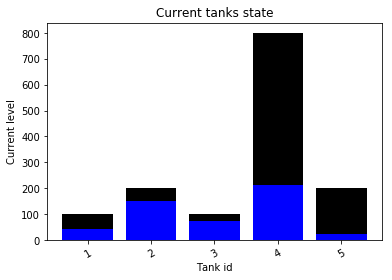

In [13]:
test_Q()
#print(np.mean(test_rewards_list) )

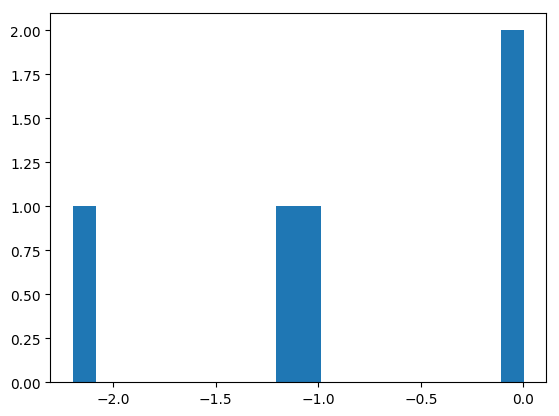

In [14]:
%matplotlib inline
mpl.rcParams.update(mpl.rcParamsDefault)
plt.hist(test_rewards_list, bins = 20)
plt.show()

In [16]:
# Visualizing test simulation:

# test_anim = ut.create_system_animation(test_visualization_steps, test_episodes * episode_length,test_freq)
# HTML(test_anim.to_html5_video())


/home/dsalgador/anaconda3/lib/python3.6/site-packages/pandas/core/series.py:696: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self.loc[key]


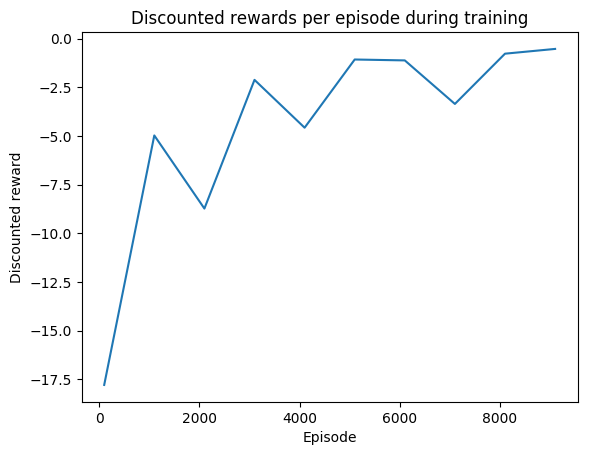

In [15]:
# Visualizing train simulation:

episode =episodes
#simulation_id = 2
step = 30
# discrewards_list = ut.load_obj(simulation_directory+"/discrewards/discrew-train-sim" + f"{simulation_id}" + "-" + f"{episode}")

# discrewards_list2 = [discrewards_list[i] for i in range(0,len(discrewards_list),step)]

# p = plt.plot([i for i in range(0,len(discrewards_list),step)], 
#              discrewards_list2)
# plt.savefig(simulation_directory+'/discrewards-sim' + f'{simulation_id}' + '.png')

discrewards = pd.read_table(rewards_file, sep = ",")

indices = [i for i in range(0,episodes,10)]

plt.plot(discrewards['episode'][indices],discrewards['discreward'][indices], label = "Discounted rewards")
plt.title("Discounted rewards per episode during training")
plt.xlabel("Episode")
plt.ylabel("Discounted reward")

plt.show()
plt.close()


In [18]:
discrewards['episode'][ [i for i in range(10)]]

0     100
1     200
2     300
3     400
4     500
5     600
6     700
7     800
8     900
9    1000
Name: episode, dtype: int64

In [19]:
len(list(Q))

14023

In [20]:
tank_levels = [test_visualization_steps[i][2] for i in range(len(test_visualization_steps))]
tank_levels_array = np.asarray(tank_levels).transpose()

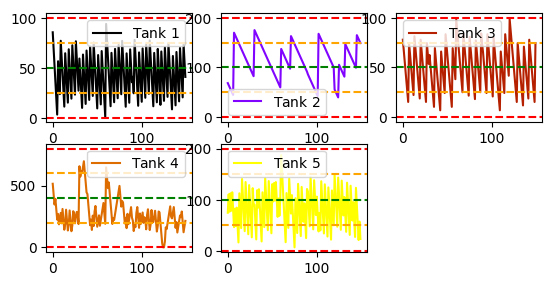

In [21]:
#DISCRETE LEVELS

cmap = plt.get_cmap('gnuplot')
colors = [cmap(i) for i in np.linspace(0, 1, n)]
lvl_colors = ["Orange", "Green","Orange"]

tanks = test_toy_system.tanks

for i, color in enumerate(colors, start=1):
    plt.subplot(3,3, i)    
    plt.plot(tank_levels_array[i-1], color=color, label='Tank ${i}$'.format(i=i))
    
    plt.axhline(y= tanks[i-1].max_load, xmin=0, xmax=episode_length, hold=None, color = "Red", linestyle = '--')
    for lvl_color, lvl in zip(lvl_colors, tanks[i-1].levels):
        plt.axhline(y= lvl, xmin=0, xmax=episode_length, hold=None, color = lvl_color, linestyle = '--')
    plt.axhline(y= 0, xmin=0, xmax=episode_length, hold=None, color = "Red", linestyle = '--')


    plt.legend(loc='best')
plt.show()

        

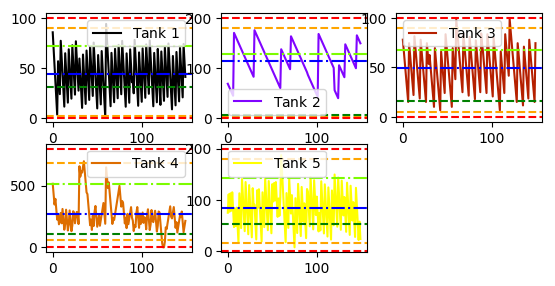

In [22]:
# THE REAL LEVELS (percentages 12h, 36h, ? h)

cmap = plt.get_cmap('gnuplot')
colors = [cmap(i) for i in np.linspace(0, 1, n)]
lvl_colors = ["Orange", "Green","Orange"]

tanks = test_toy_system.tanks

for i, color in enumerate(colors, start=1):
    plt.subplot(3,3, i)    

    plt.plot(tank_levels_array[i-1], color=color, label='Tank ${i}$'.format(i=i))
    
    plt.axhline(y= tanks[i-1].max_load, xmin=0, xmax=episode_length, hold=None, color = "Red", linestyle = '--')
    for lvl_color, lvl in zip(lvl_colors, tanks[i-1].level_percentages):
        plt.axhline(y= lvl * tanks[i-1].max_load, xmin=0, xmax=episode_length, hold=None, color = lvl_color, 
                    linestyle = '--')
    plt.axhline(y= 0, xmin=0, xmax=episode_length, hold=None, color = "Red", linestyle = '--')
    
    
    percentages = tanks[i-1].level_percentages           
    c = percentages[1]
    e = percentages[2]          
    d = ct.p0_GLOBAL*e+(1-ct.p0_GLOBAL)*c
    plt.axhline(y= d*tanks[i-1].max_load, xmin=0, xmax=episode_length, hold=None, color = "lawngreen", 
                linestyle = '-.')

    plt.axhline(y= np.mean(tank_levels_array[i-1]), xmin=0, xmax=episode_length, hold=None, 
                color = "blue", linestyle = '-.')
  


    plt.legend(loc='best')
#plt.show()
plt.savefig(simulation_directory + '/tank-levels-sim' + '{}'.format(simulation_id) + '.pdf')

### Test visualization

In [16]:
def visualize_simulation(states_file,
                        test_toy_system,
                        simulation_id,
                        simulation_directory):
    test_states = pd.read_table(states_file, sep = ",")
    test_states.head()


    cmap = plt.get_cmap('gnuplot')
    colors = [cmap(i) for i in np.linspace(0, 1, n)]
    lvl_colors = ["Orange", "Green","Orange"]

    tanks = test_toy_system.tanks

    for i, color in enumerate(colors, start=1):    
        plt.subplot(2,3,i)
        states = test_states['stock{}'.format(i-1)]
        plt.plot(test_states['step'],states, label = "Shop {}".format(i-1), color = "Black")
        plt.title("Shop {}".format(i-1))

        plt.axhline(y= tanks[i-1].max_load, xmin=0, xmax=episode_length, hold=None, color = "Red", linestyle = '--')
        for lvl_color, lvl in zip(lvl_colors, tanks[i-1].level_percentages):
            plt.axhline(y= lvl * tanks[i-1].max_load, xmin=0, xmax=episode_length, hold=None, color = lvl_color, 
                        linestyle = '--')
        plt.axhline(y= 0, xmin=0, xmax=episode_length, hold=None, color = "Red", linestyle = '--')


        percentages = tanks[i-1].level_percentages           
        c = percentages[1]
        e = percentages[2]          
        d = ct.p0_GLOBAL*e+(1-ct.p0_GLOBAL)*c
        plt.axhline(y= d*tanks[i-1].max_load, xmin=0, xmax=episode_length, hold=None, color = "lawngreen", 
                    linestyle = '-.')

        plt.axhline(y= np.mean(states), xmin=0, xmax=episode_length, hold=None, 
                    color = "blue", linestyle = '-.')
        plt.xticks(range(0,episode_length+1,5))


    plt.subplot(2,3,6)
    plt.title("Legend")
    plt.axis('off')

    #plt.legend(bbox_to_anchor=(0.5 ,0.8), loc=2, borderaxespad=0.)
    plt.yticks([])
    plt.xticks([])

    patch1 = mpatches.Patch(color='red', label='Max/Min capacities', linestyle = '--', fill = False, linewidth = 2)
    patch2 = mpatches.Patch(color='orange', label='Max/Min levels', linestyle = '--', fill = False, linewidth = 2)
    patch3 = mpatches.Patch(color='green', label='Danger level', linestyle = '--', fill = False, linewidth = 2)
    patch4 = mpatches.Patch(color='lawngreen', label='Max reward level (M)', linestyle = '-.', fill = False, linewidth = 2)
    patch5 = mpatches.Patch(color='blue', label='Observed mean level', linestyle = '-.', fill = False, linewidth = 2)
    patch6 = mpatches.Patch(color='black', label='Current stock level', linestyle = '-', fill = False, linewidth = 2)


    plt.legend(handles=[patch1, patch2, patch3, patch4, patch5, patch6], loc = 'center')

    plt.tight_layout() 
    plt.savefig(simulation_directory + '/tank-levels-sim' + '{}'.format(simulation_id) + '.pdf')
    plt.show()
    plt.close()


## Simulations

In [17]:

def test_simulation(simulation_id,
                   max_episodes,
                   n_episodes = 1,
                   noise = False):
    
    # Initialize directories and files
    
    simulation_directory = './simulations/simulation{}'.format(simulation_id)
    rewards_file = simulation_directory+'/discrewards'+ '/rewards-sim{}.csv'.format(simulation_id)
    states_file = simulation_directory+'/vis'+ '/states-sim{}.csv'.format(simulation_id) # for testing
    
    with open(states_file,'w') as f:
         np.savetxt(f, [["step", "stock0", "stock1", "stock2","stock3", "stock4"]], fmt="%s", delimiter=',') 

    # Initialize system
    episodes = max_episodes#100000

    tanks, trucks, graph, weights_matrix = initialize_test_system(noise, seed =episodes+1)
    test_toy_system = model.System(tanks = tanks, trucks = trucks, adjacency_matrix = graph, weights_matrix = weights_matrix)

    Q = ut.load_obj(simulation_directory + "/Q-dictionaries/Q-dict-sim" + "{}".format(simulation_id) + "-" + "{}".format(episodes))


    test_episodes = n_episodes
    episode_length =30
    test_freq = 1
    test_verbose = True

    test_visualization_steps = []
    test_rewards_list = []
    test_level_rewards_list = []
    test_transport_rewards_list = []
    test_trucks_sent_list = []
    test_number_of_first_trucks_sent_list = []
    test_number_of_second_trucks_sent_list = []
    
        
    test_Q(n_episodes = test_episodes, 
           episode_length = episode_length,
           system = test_toy_system,
           visualization_steps = test_visualization_steps, 
           rewards_list = test_rewards_list,
           level_rewards_list = test_level_rewards_list,
           transport_rewards_list = test_transport_rewards_list,
           trucks_sent_list = test_trucks_sent_list,
           number_of_first_trucks_sent_list = test_number_of_first_trucks_sent_list,           
           number_of_second_trucks_sent_list=test_number_of_second_trucks_sent_list,           
           freq = test_freq,
           test_verbose = test_verbose ,
           states_file = states_file, 
           Q = Q 
          )
            
    visualize_simulation(states_file,
                        test_toy_system,
                        simulation_id,
                        simulation_directory)   
    print("Total discounted rewards","Level rewards", "Transport rewards")
    print(sum(test_rewards_list)/n_episodes, sum(test_level_rewards_list)/n_episodes,sum(test_transport_rewards_list)/n_episodes )
    print("Average trucks sent: ", sum(test_trucks_sent_list)/n_episodes)
    
    if n_episodes == 1:
        print("1st type Trucks sent to each shop:", test_number_of_first_trucks_sent_list)
        print("2nd type Trucks sent to each shop:", test_number_of_second_trucks_sent_list)

    
test_episodes = 1

### Deterministic consumption rates without transport/unload costs, 1M episodes 

Test episode: 1
Episode 1 t 0 0.0003515 0.0003515 0.0 5500
Episode 1 t 1 3.48e-05 3.48e-05 0.0 3400
Episode 1 t 2 2.25e-05 2.25e-05 0.0 5500
Episode 1 t 3 0.0004013 0.0004013 0.0 5500
Episode 1 t 4 0.0005056 0.0005056 0.0 0300
Episode 1 t 5 0.0001066 0.0001066 0.0 1400
Episode 1 t 6 2.63e-05 2.63e-05 0.0 2300
Episode 1 t 7 0.0002706 0.0002706 0.0 5500
Episode 1 t 8 0.0006779 0.0006779 0.0 0300
Episode 1 t 9 3.04e-05 3.04e-05 0.0 3400
Episode 1 t 10 2.22e-05 2.22e-05 0.0 4300
Episode 1 t 11 0.0001303 0.0001303 0.0 5500
Episode 1 t 12 0.0006989 0.0006989 0.0 2300
Episode 1 t 13 2.74e-05 2.74e-05 0.0 0300
Episode 1 t 14 0.0007843 0.0007843 0.0 5500
Episode 1 t 15 1.61e-05 1.61e-05 0.0 4300
Episode 1 t 16 0.0012624 0.0012624 0.0 5500
Episode 1 t 17 -0.0010264 -0.0010264 0.0 0400
Episode 1 t 18 1.58e-05 1.58e-05 0.0 3300
Episode 1 t 19 1.37e-05 1.37e-05 0.0 2300
Episode 1 t 20 0.0012951 0.0012951 0.0 5500
Episode 1 t 21 -0.0011389 -0.0011389 0.0 0400
Episode 1 t 22 2e-05 2e-05 0.0 3300
Epis

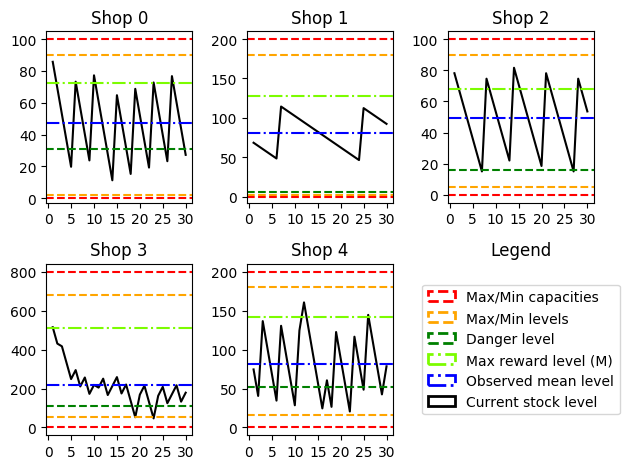

Total discounted rewards Level rewards Transport rewards
0.0021829023973387483 0.0064378889110611615 0.0
Average trucks sent:  41.0
1st type Trucks sent to each shop: [array([ 6,  2,  4,  5,  3, 10])]
2nd type Trucks sent to each shop: [array([ 0,  0,  0, 15,  6,  9])]


In [18]:
test_simulation(simulation_id=16, max_episodes = 10**5,n_episodes = test_episodes)


### Deterministic consumption rates WITH transport/unload costs, 100K episodes 

Test episode: 1
Episode 1 t 0 0.0003515 0.0003515 0.0 5500
Episode 1 t 1 2.63e-05 2.63e-05 0.0 4500
Episode 1 t 2 0.0002791 0.0002791 0.0 5500
Episode 1 t 3 0.0004007 0.0004007 0.0 4500
Episode 1 t 4 0.000226 0.000226 0.0 0300
Episode 1 t 5 0.000106 0.000106 0.0 1400
Episode 1 t 6 2.57e-05 2.57e-05 0.0 2300
Episode 1 t 7 0.000275 0.000275 0.0 3300
Episode 1 t 8 0.0004001 0.0004001 0.0 0500
Episode 1 t 9 2.31e-05 2.31e-05 0.0 4500
Episode 1 t 10 0.0003349 0.0003349 0.0 5300
Episode 1 t 11 0.0001262 0.0001262 0.0 4300
Episode 1 t 12 0.0009566 0.0009566 0.0 2500
Episode 1 t 13 0.0009862 0.0009862 0.0 0400
Episode 1 t 14 2.62e-05 2.62e-05 0.0 3300
Episode 1 t 15 0.0003978 0.0003978 0.0 1500
Episode 1 t 16 0.0009887 0.0009887 0.0 3300
Episode 1 t 17 2.93e-05 2.93e-05 0.0 0400
Episode 1 t 18 2.31e-05 2.31e-05 0.0 3300
Episode 1 t 19 1.89e-05 1.89e-05 0.0 2500
Episode 1 t 20 0.0010266 0.0010266 0.0 3300
Episode 1 t 21 3.73e-05 3.73e-05 0.0 0400
Episode 1 t 22 3.04e-05 3.04e-05 0.0 3300
Episod

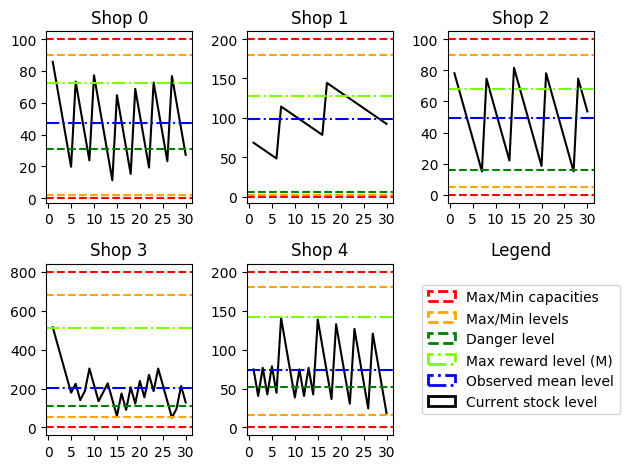

Total discounted rewards Level rewards Transport rewards
0.0026465446393608852 0.009284931221522767 0.0
Average trucks sent:  42.0
1st type Trucks sent to each shop: [array([6, 2, 4, 7, 5, 6])]
2nd type Trucks sent to each shop: [array([ 0,  0,  0, 13,  5, 12])]


In [19]:
test_simulation(simulation_id= 17, max_episodes = 100000, n_episodes = test_episodes)

Test episode: 1
Episode 1 t 0 0.0003515 0.0003515 0.0 5500
Episode 1 t 1 3.3e-05 3.3e-05 0.0 5400
Episode 1 t 2 2.07e-05 2.07e-05 0.0 5500
Episode 1 t 3 0.0003996 0.0003996 0.0 5500
Episode 1 t 4 0.0005038 0.0005038 0.0 0300
Episode 1 t 5 0.0001049 0.0001049 0.0 1400
Episode 1 t 6 2.46e-05 2.46e-05 0.0 2300
Episode 1 t 7 0.0002721 0.0002721 0.0 5300
Episode 1 t 8 0.0006762 0.0006762 0.0 0500
Episode 1 t 9 2.87e-05 2.87e-05 0.0 3400
Episode 1 t 10 1.97e-05 1.97e-05 0.0 5300
Episode 1 t 11 0.000124 0.000124 0.0 5300
Episode 1 t 12 0.0015121 0.0015121 0.0 2500
Episode 1 t 13 0.0009839 0.0009839 0.0 0400
Episode 1 t 14 0.0001545 0.0001545 0.0 5300
Episode 1 t 15 5.51e-05 5.51e-05 0.0 5300
Episode 1 t 16 0.0015417 0.0015417 0.0 5300
Episode 1 t 17 -0.9999834 -0.9999834 0.0 0500
Episode 1 t 18 0.0004559 0.0004559 0.0 4300
Episode 1 t 19 0.0007266 0.0007266 0.0 4300
Episode 1 t 20 0.0008086 0.0008086 0.0 2500
Episode 1 t 21 -0.0005068 -0.0005068 0.0 5400
Episode 1 t 22 0.0005457 0.0005457 0.0

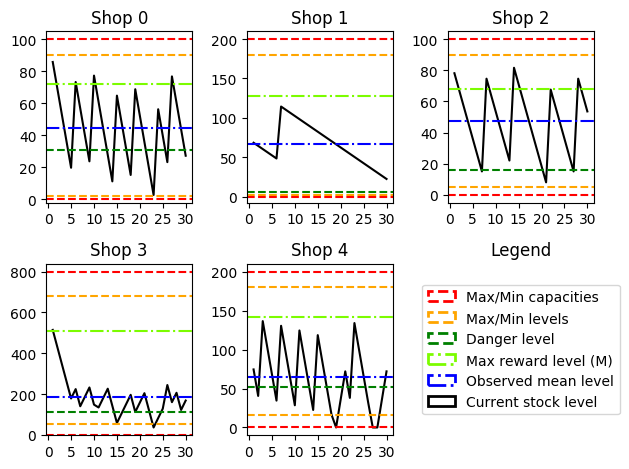

Total discounted rewards Level rewards Transport rewards
-0.30016321885601066 -2.9884983418039552 0.0
Average trucks sent:  38.0
1st type Trucks sent to each shop: [array([ 6,  1,  4,  2,  4, 13])]
2nd type Trucks sent to each shop: [array([ 0,  0,  0, 16,  5,  9])]


In [20]:
test_simulation(simulation_id= 18, max_episodes = 100000, n_episodes = test_episodes)

Test episode: 1
Episode 1 t 0 0.0003515 0.0003515 0.0 5500
Episode 1 t 1 -0.0030491 -0.0030491 0.0 5500
Episode 1 t 2 -0.9999849 -0.9999849 0.0 5500
Episode 1 t 3 -0.9996023 -0.9996023 0.0 5500
Episode 1 t 4 -0.9987266 -0.9987266 0.0 5500
Episode 1 t 5 -2.0266904 -2.0266904 0.0 5500
Episode 1 t 6 -3.0010629 -3.0010629 0.0 5500
Episode 1 t 7 -3.9999975 -3.9999975 0.0 5500
Episode 1 t 8 -3.9999978 -3.9999978 0.0 5500
Episode 1 t 9 -3.9999982 -3.9999982 0.0 5500
Episode 1 t 10 -3.9999985 -3.9999985 0.0 5500
Episode 1 t 11 -3.9999988 -3.9999988 0.0 5500
Episode 1 t 12 -3.9999991 -3.9999991 0.0 5500
Episode 1 t 13 -3.9999995 -3.9999995 0.0 5500
Episode 1 t 14 -3.9999998 -3.9999998 0.0 5500
Episode 1 t 15 -3.9995899 -3.9995899 0.0 5500
Episode 1 t 16 -4.0331813 -4.0331813 0.0 5500
Episode 1 t 17 -5.0 -5.0 0.0 5500
Episode 1 t 18 -5.0 -5.0 0.0 5500
Episode 1 t 19 -5.0 -5.0 0.0 5500
Episode 1 t 20 -5.0 -5.0 0.0 5500
Episode 1 t 21 -5.0 -5.0 0.0 5500
Episode 1 t 22 -5.0 -5.0 0.0 5500
Episode 1 

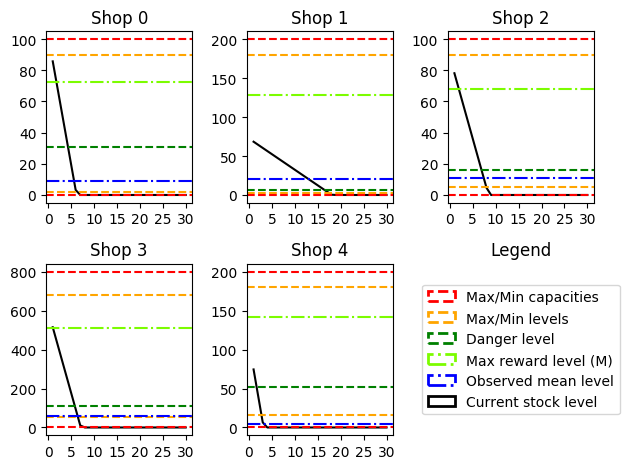

Total discounted rewards Level rewards Transport rewards
-23.674079595523956 -113.06152520212376 0.0
Average trucks sent:  0.0
1st type Trucks sent to each shop: [array([ 0,  0,  0,  0,  0, 30])]
2nd type Trucks sent to each shop: [array([ 0,  0,  0,  0,  0, 30])]


In [21]:
test_simulation(simulation_id= 21, max_episodes = 100000, n_episodes = test_episodes)

Test episode: 1
Episode 1 t 0 0.0003515 0.0003515 0.0 5500
Episode 1 t 1 2.63e-05 2.63e-05 0.0 4500
Episode 1 t 2 0.0002791 0.0002791 0.0 5500
Episode 1 t 3 0.0004007 0.0004007 0.0 4500
Episode 1 t 4 0.0005339 0.0005339 0.0 0500
Episode 1 t 5 -0.026681 -0.026681 0.0 4500
Episode 1 t 6 8.15e-05 8.15e-05 0.0 5300
Truck 1 in tank 0 does not deliver
Episode 1 t 7 -2.0009778 -1.0009778 0.0 2000
Episode 1 t 8 -0.9990739 -0.9990739 0.0 4500
Episode 1 t 9 -1.9999893 -1.9999893 0.0 4500
Episode 1 t 10 -0.9999481 -0.9999481 0.0 0500
Episode 1 t 11 -0.9990043 -0.9990043 0.0 1500
Episode 1 t 12 -0.9992328 -0.9992328 0.0 4500
Episode 1 t 13 -1.0134624 -1.0134624 0.0 0500
Episode 1 t 14 -1.9999874 -1.9999874 0.0 4500
Episode 1 t 15 -0.9991085 -0.9991085 0.0 2500
Episode 1 t 16 -0.9997637 -0.9997637 0.0 4500
Episode 1 t 17 -0.9991644 -0.9991644 0.0 0500
Episode 1 t 18 -0.9999849 -0.9999849 0.0 4500
Episode 1 t 19 -0.9992281 -0.9992281 0.0 5500
Episode 1 t 20 -0.9990907 -0.9990907 0.0 4500
Episode 1 t

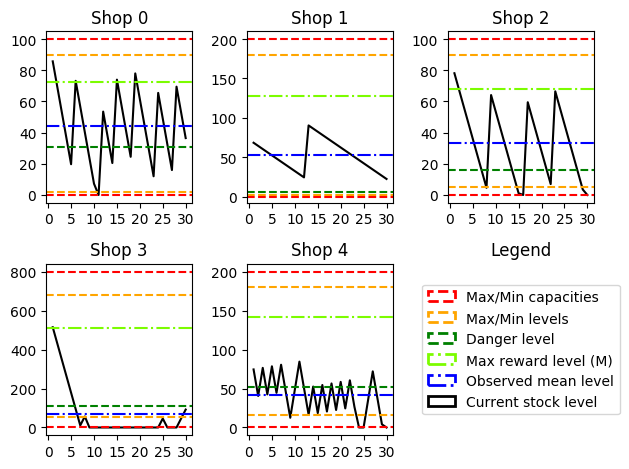

Total discounted rewards Level rewards Transport rewards
-5.6799811964097175 -26.14305535850526 0.0
Average trucks sent:  30.0
1st type Trucks sent to each shop: [array([ 6,  1,  4,  0, 12,  7])]
2nd type Trucks sent to each shop: [array([ 3,  0,  0,  4,  0, 23])]


In [22]:
test_simulation(simulation_id= 22, max_episodes = 100000, n_episodes = test_episodes)

Test episode: 1
Episode 1 t 0 0.0003515 0.0003515 0.0 5500
Episode 1 t 1 3.3e-05 3.3e-05 0.0 5400
Episode 1 t 2 2.07e-05 2.07e-05 0.0 5500
Episode 1 t 3 0.0003996 0.0003996 0.0 5500
Episode 1 t 4 0.0005038 0.0005038 0.0 0300
Episode 1 t 5 9.24e-05 9.24e-05 0.0 4500
Episode 1 t 6 0.0004445 0.0004445 0.0 2300
Episode 1 t 7 -0.0630015 -0.0630015 0.0 5500
Episode 1 t 8 -0.9999824 -0.9999824 0.0 0300
Episode 1 t 9 0.0013051 0.0013051 0.0 4500
Truck 1 in tank 0 does not deliver
Episode 1 t 10 -1.9999898 -0.9999898 0.0 4000
Episode 1 t 11 -0.0006721 -0.0006721 0.0 1300
Episode 1 t 12 -0.9989064 -0.9989064 0.0 1400
Episode 1 t 13 -0.0155711 -0.0155711 0.0 0300
Episode 1 t 14 0.0003776 0.0003776 0.0 2300
Episode 1 t 15 0.0005698 0.0005698 0.0 5300
Episode 1 t 16 0.0005593 0.0005593 0.0 4300
Episode 1 t 17 0.000523 0.000523 0.0 0300
Episode 1 t 18 1.76e-05 1.76e-05 0.0 4500
Episode 1 t 19 0.0004628 0.0004628 0.0 2300
Episode 1 t 20 0.0004307 0.0004307 0.0 4300
Episode 1 t 21 0.000417 0.000417 0.

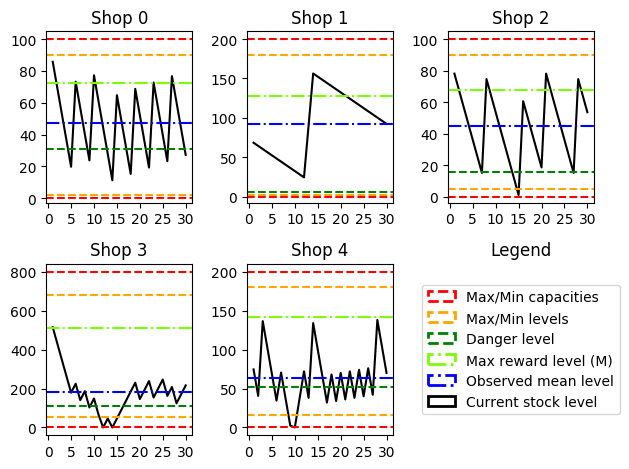

Total discounted rewards Level rewards Transport rewards
-1.4417129347730597 -3.069216702498232 0.0
Average trucks sent:  40.0
1st type Trucks sent to each shop: [array([ 6,  2,  4,  0,  8, 10])]
2nd type Trucks sent to each shop: [array([ 1,  0,  0, 16,  3, 10])]


In [23]:
test_simulation(simulation_id= 23, max_episodes = 100000, n_episodes = test_episodes)

### Stochastic consumption rates without transport/unload costs, 100K episodes 

Test episode: 1
Episode 1 t 0 3.82e-05 3.82e-05 0.0 4500
Episode 1 t 1 2.6e-05 2.6e-05 0.0 5500
Truck 1 in tank 4 does not deliver
Episode 1 t 2 -0.9997768 0.0002232 0.0 5400
Episode 1 t 3 0.0004609 0.0004609 0.0 5400
Episode 1 t 4 2.4e-05 2.4e-05 0.0 0300
Episode 1 t 5 1.29e-05 1.29e-05 0.0 2100
Episode 1 t 6 0.0011607 0.0011607 0.0 5500
Episode 1 t 7 0.0002634 0.0002634 0.0 4300
Episode 1 t 8 0.0003533 0.0003533 0.0 0300
Episode 1 t 9 2.2e-05 2.2e-05 0.0 4300
Episode 1 t 10 0.0003221 0.0003221 0.0 5300
Episode 1 t 11 5.55e-05 5.55e-05 0.0 5400
Episode 1 t 12 0.0006198 0.0006198 0.0 2300
Episode 1 t 13 2.97e-05 2.97e-05 0.0 0300
Episode 1 t 14 3.18e-05 3.18e-05 0.0 4300
Episode 1 t 15 2.08e-05 2.08e-05 0.0 5500
Episode 1 t 16 0.0004311 0.0004311 0.0 4300
Episode 1 t 17 2.84e-05 2.84e-05 0.0 0300
Episode 1 t 18 2.68e-05 2.68e-05 0.0 4300
Episode 1 t 19 2.21e-05 2.21e-05 0.0 2500
Episode 1 t 20 0.0003414 0.0003414 0.0 4300
Episode 1 t 21 2.98e-05 2.98e-05 0.0 0500
Episode 1 t 22 3.1e-05

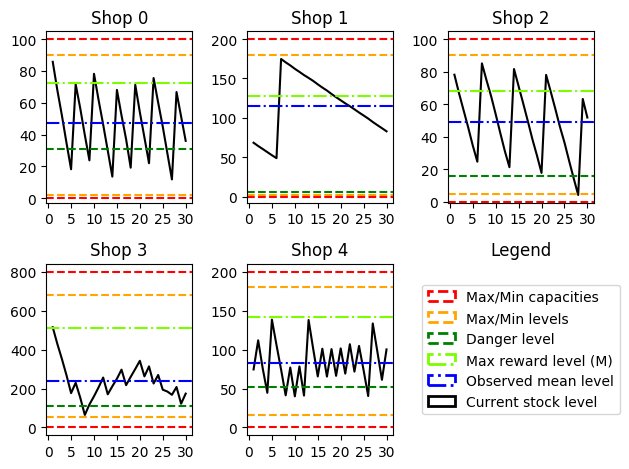

Total discounted rewards Level rewards Transport rewards
-0.8661421960658632 0.005087555789399755 0.0
Average trucks sent:  44.0
1st type Trucks sent to each shop: [array([6, 0, 4, 3, 9, 8])]
2nd type Trucks sent to each shop: [array([ 0,  1,  0, 16,  5,  8])]


In [24]:
test_simulation(simulation_id= 14, max_episodes = 100000,n_episodes = test_episodes, noise = True)

Test episode: 1
Episode 1 t 0 3.73e-05 3.73e-05 0.0 4300
Episode 1 t 1 2.92e-05 2.92e-05 0.0 5500
Episode 1 t 2 2.5e-05 2.5e-05 0.0 4500
Episode 1 t 3 0.0004575 0.0004575 0.0 5500
Episode 1 t 4 0.0001911 0.0001911 0.0 0500
Episode 1 t 5 2.19e-05 2.19e-05 0.0 2400
Truck 0 in tank 4 does not deliver
Episode 1 t 6 -0.9999795 2.05e-05 0.0 4300
Episode 1 t 7 0.0002723 0.0002723 0.0 1300
Episode 1 t 8 0.0003611 0.0003611 0.0 0300
Episode 1 t 9 3.39e-05 3.39e-05 0.0 3400
Truck 0 in tank 4 does not deliver
Episode 1 t 10 -0.9999753 2.47e-05 0.0 4300
Episode 1 t 11 5.08e-05 5.08e-05 0.0 5500
Episode 1 t 12 0.0011994 0.0011994 0.0 2300
Episode 1 t 13 3.4e-05 3.4e-05 0.0 0400
Episode 1 t 14 2.89e-05 2.89e-05 0.0 3300
Episode 1 t 15 2.8e-05 2.8e-05 0.0 4300
Episode 1 t 16 0.000426 0.000426 0.0 5500
Episode 1 t 17 1.93e-05 1.93e-05 0.0 0500
Episode 1 t 18 0.0008625 0.0008625 0.0 3300
Episode 1 t 19 2.15e-05 2.15e-05 0.0 2400
Episode 1 t 20 0.0003297 0.0003297 0.0 5500
Episode 1 t 21 3.08e-05 3.08e-

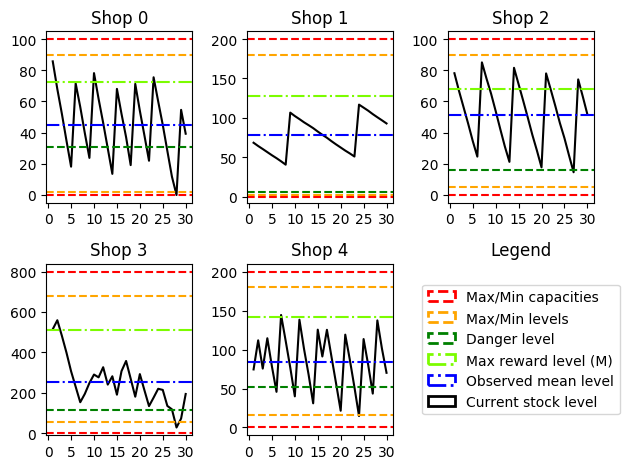

Total discounted rewards Level rewards Transport rewards
-0.9433240320446407 -0.9965190888456126 0.0
Average trucks sent:  44.0
1st type Trucks sent to each shop: [array([6, 2, 4, 6, 6, 6])]
2nd type Trucks sent to each shop: [array([ 0,  0,  0, 14,  6, 10])]


In [25]:
test_simulation(simulation_id= 24, max_episodes = 100000,n_episodes = test_episodes, noise = True)

### Stochastic consumption rates WITH transport/unload costs, 100K episodes 


Test episode: 1
Episode 1 t 0 0.0003142 0.0003142 0.0 5500
Episode 1 t 1 2.6e-05 2.6e-05 0.0 4500
Episode 1 t 2 2.17e-05 2.17e-05 0.0 4500
Episode 1 t 3 0.0004542 0.0004542 0.0 5500
Episode 1 t 4 0.0001911 0.0001911 0.0 0300
Episode 1 t 5 2.19e-05 2.19e-05 0.0 2400
Episode 1 t 6 2.23e-05 2.23e-05 0.0 3300
Episode 1 t 7 0.0002708 0.0002708 0.0 1500
Episode 1 t 8 0.0003596 0.0003596 0.0 0300
Episode 1 t 9 2.39e-05 2.39e-05 0.0 4500
Episode 1 t 10 0.0003186 0.0003186 0.0 1300
Episode 1 t 11 4.86e-05 4.86e-05 0.0 4300
Episode 1 t 12 0.0010176 0.0010176 0.0 4300
Truck 1 in tank 2 does not deliver
Episode 1 t 13 -1.0165129 -0.0165129 0.0 0200
Episode 1 t 14 0.0003263 0.0003263 0.0 2300
Episode 1 t 15 1.85e-05 1.85e-05 0.0 4500
Episode 1 t 16 0.0004287 0.0004287 0.0 4300
Episode 1 t 17 2.65e-05 2.65e-05 0.0 0300
Episode 1 t 18 2.27e-05 2.27e-05 0.0 4500
Episode 1 t 19 2.23e-05 2.23e-05 0.0 2300
Episode 1 t 20 0.0003385 0.0003385 0.0 4500
Episode 1 t 21 3.02e-05 3.02e-05 0.0 0300
Episode 1 t 2

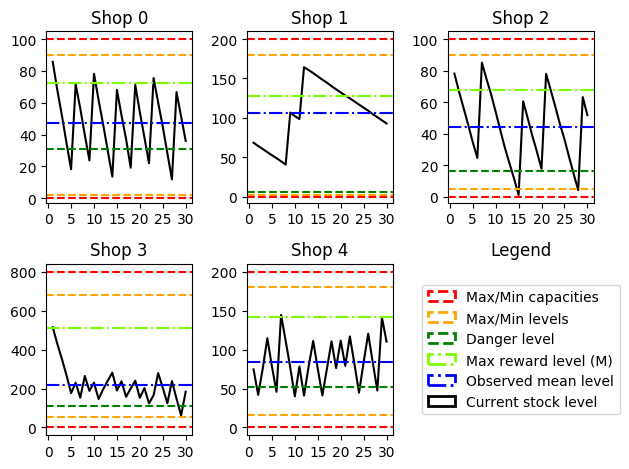

Total discounted rewards Level rewards Transport rewards
-0.3211407570255761 -0.01075598877399876 0.0
Average trucks sent:  47.0
1st type Trucks sent to each shop: [array([ 6,  2,  4,  5, 11,  2])]
2nd type Trucks sent to each shop: [array([ 0,  0,  2, 15,  2, 11])]


In [26]:
test_simulation(simulation_id= 19, max_episodes = 100000,n_episodes = test_episodes, noise = True)

Test episode: 1
Episode 1 t 0 0.0003142 0.0003142 0.0 5500
Episode 1 t 1 2.6e-05 2.6e-05 0.0 4500
Episode 1 t 2 0.0002232 0.0002232 0.0 5500
Episode 1 t 3 0.0004542 0.0004542 0.0 4500
Episode 1 t 4 0.0001911 0.0001911 0.0 0300
Episode 1 t 5 0.0001045 0.0001045 0.0 5400
Episode 1 t 6 -0.0010353 -0.0010353 0.0 5300
Episode 1 t 7 -0.9997371 -0.9997371 0.0 1300
Truck 1 in tank 2 does not deliver
Episode 1 t 8 -1.9988697 -0.9988697 0.0 5200
Truck 1 in tank 0 does not deliver
Episode 1 t 9 -2.999349 -1.999349 0.0 4000
Episode 1 t 10 -0.9996798 -0.9996798 0.0 0300
Episode 1 t 11 -1.0013345 -1.0013345 0.0 1400
Episode 1 t 12 0.0008784 0.0008784 0.0 2300
Episode 1 t 13 2.12e-05 2.12e-05 0.0 0300
Episode 1 t 14 0.0006002 0.0006002 0.0 5300
Episode 1 t 15 0.0004553 0.0004553 0.0 4500
Episode 1 t 16 0.0007256 0.0007256 0.0 5300
Episode 1 t 17 0.0015484 0.0015484 0.0 4300
Truck 1 in tank 0 does not deliver
Episode 1 t 18 -1.9988808 -0.9988808 0.0 2000
Episode 1 t 19 -0.999968 -0.999968 0.0 0400
Epi

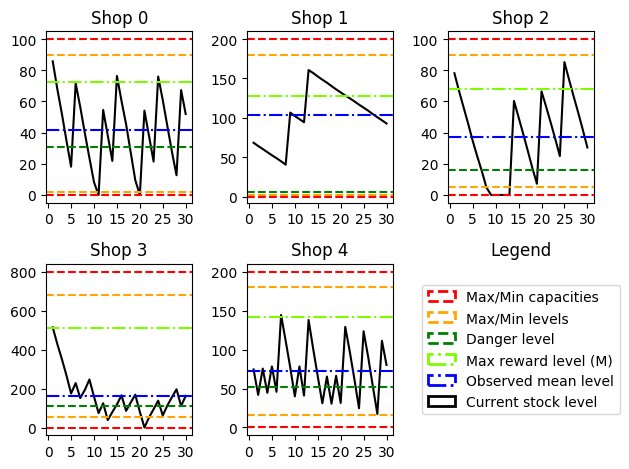

Total discounted rewards Level rewards Transport rewards
-3.596937787350254 -7.990089695224482 0.0
Average trucks sent:  41.0
1st type Trucks sent to each shop: [array([ 6,  2,  3,  0,  5, 14])]
2nd type Trucks sent to each shop: [array([ 2,  0,  1, 17,  5,  5])]


In [27]:
test_simulation(simulation_id= 20, max_episodes = 100000,n_episodes = test_episodes, noise = True)

Test episode: 1
Episode 1 t 0 3.82e-05 3.82e-05 0.0 4500
Episode 1 t 1 2.6e-05 2.6e-05 0.0 5500
Episode 1 t 2 2.17e-05 2.17e-05 0.0 4500
Episode 1 t 3 0.0004542 0.0004542 0.0 5500
Episode 1 t 4 0.0001911 0.0001911 0.0 0300
Episode 1 t 5 -0.001079 -0.001079 0.0 2500
Truck 0 in tank 0 does not deliver
Episode 1 t 6 -0.9991312 0.0008688 0.0 0400
Episode 1 t 7 0.0012263 0.0012263 0.0 3500
Truck 1 in tank 0 does not deliver
Episode 1 t 8 -1.9988693 -0.9988693 0.0 5000
Episode 1 t 9 -1.0011711 -1.0011711 0.0 4300
Truck 1 in tank 0 does not deliver
Episode 1 t 10 -2.999989 -1.999989 0.0 4000
Truck 1 in tank 0 does not deliver
Episode 1 t 11 -2.9999894 -1.9999894 0.0 4000
Truck 1 in tank 0 does not deliver
Episode 1 t 12 -2.9999887 -1.9999887 0.0 2000
Episode 1 t 13 -0.0013925 -0.0013925 0.0 0300
Episode 1 t 14 0.000795 0.000795 0.0 1300
Episode 1 t 15 0.0002728 0.0002728 0.0 4300
Episode 1 t 16 0.0003371 0.0003371 0.0 0300
Episode 1 t 17 1.92e-05 1.92e-05 0.0 4300
Episode 1 t 18 1.44e-05 1.44

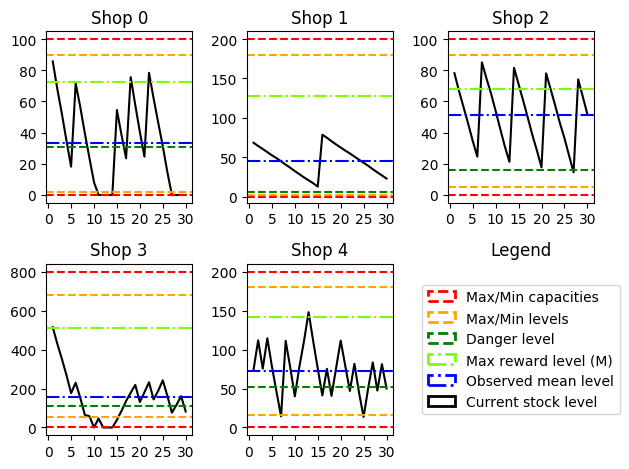

Total discounted rewards Level rewards Transport rewards
-5.125758821395453 -13.995636290364592 0.0
Average trucks sent:  44.0
1st type Trucks sent to each shop: [array([ 5,  1,  4,  1, 12,  7])]
2nd type Trucks sent to each shop: [array([ 7,  0,  0, 13,  1,  9])]


In [28]:
test_simulation(simulation_id= 25, max_episodes = 100000,n_episodes = test_episodes, noise = True)

In [36]:
a = '1200'

In [37]:
a[0].count('0')

0

In [38]:
np.zeros(n, dtype = np.int64)

array([0, 0, 0, 0, 0])

In [39]:
int(a[0])

1

Test episode: 1
Episode 1 t 0 3.86e-05 3.86e-05 0.0 4500
Episode 1 t 1 2.63e-05 2.63e-05 0.0 5500
Episode 1 t 2 2.19e-05 2.19e-05 0.0 4500
Episode 1 t 3 0.0004007 0.0004007 0.0 5500
Episode 1 t 4 0.000226 0.000226 0.0 0300
Episode 1 t 5 9.68e-05 9.68e-05 0.0 4300
Episode 1 t 6 0.0001667 0.0001667 0.0 2500
Episode 1 t 7 0.0002686 0.0002686 0.0 4300
Episode 1 t 8 0.0001181 0.0001181 0.0 0300
Episode 1 t 9 -0.0010641 -0.0010641 0.0 5100
Episode 1 t 10 5.63e-05 5.63e-05 0.0 4300
Episode 1 t 11 0.0011084 0.0011084 0.0 3500
Episode 1 t 12 0.0006992 0.0006992 0.0 2400
Episode 1 t 13 2.88e-05 2.88e-05 0.0 0300
Episode 1 t 14 0.000234 0.000234 0.0 3300
Episode 1 t 15 2.14e-05 2.14e-05 0.0 4500
Episode 1 t 16 0.0007111 0.0007111 0.0 5500
Episode 1 t 17 -0.0010195 -0.0010195 0.0 0400
Episode 1 t 18 2.29e-05 2.29e-05 0.0 3300
Episode 1 t 19 2.08e-05 2.08e-05 0.0 2300
Episode 1 t 20 0.0007444 0.0007444 0.0 5500
Episode 1 t 21 -0.0011318 -0.0011318 0.0 0400
Truck 0 in tank 4 does not deliver
Episode

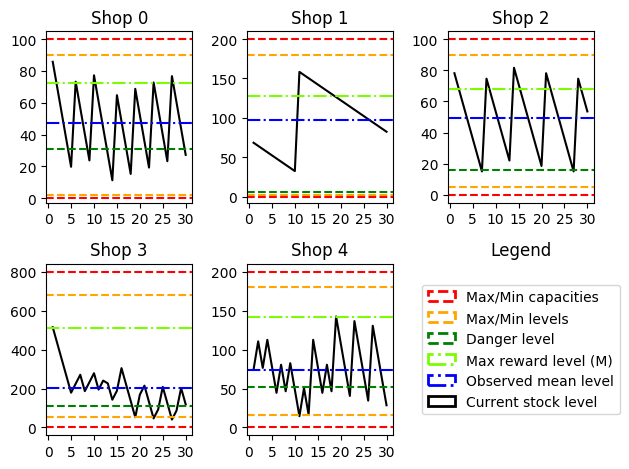

Total discounted rewards Level rewards Transport rewards
-0.09736098884530463 0.003726287937342924 0.0
Average trucks sent:  42.0
1st type Trucks sent to each shop: [array([6, 0, 4, 5, 8, 7])]
2nd type Trucks sent to each shop: [array([ 0,  1,  0, 14,  4, 11])]


In [29]:
test_simulation(simulation_id= 28, max_episodes = 10**4,n_episodes = test_episodes, noise = False)